<a href="https://colab.research.google.com/github/cassiecinzori/ECON3916/blob/main/Project/ECON3916_Project_Phase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 | Phase 2: Data Audit & Forensics
### Dataset: Mroz (1987) Female Labor Supply

#### Cassandra Cinzori

#### Set up initial environment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

print("Libraries loaded successfully.")

Libraries loaded successfully.


### Data Ingestion

In [3]:
url = "https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Mroz.csv"
df = pd.read_csv(url)

print(f"Shape: {df.shape}")  # (753, 18)

Shape: (753, 19)


### Task 1: Shape & Types Audit

In [4]:
print("\n--- .info() ---")
print(df.info())

print("\n--- .describe() ---")
print(df.describe())

# Check for any numeric variables stored as strings
# (e.g. dollar signs or commas in values)
for col in df.columns:
    if df[col].dtype == object:
        print(f"String column detected: {col} — sample values: {df[col].unique()[:5]}")

# Clean 'hearnw' and 'wagew' if stored as strings
for col in ['hearnw', 'wagew', 'wageh']:
    df[col] = (df[col].astype(str)
                       .str.replace('$', '', regex=False)
                       .str.replace(',', '', regex=False)
                       .astype(float))

print("\nCleaning complete. dtypes:")
print(df[['hearnw', 'wagew', 'wageh']].dtypes)



--- .info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rownames    753 non-null    int64  
 1   work        753 non-null    object 
 2   hoursw      753 non-null    int64  
 3   child6      753 non-null    int64  
 4   child618    753 non-null    int64  
 5   agew        753 non-null    int64  
 6   educw       753 non-null    int64  
 7   hearnw      753 non-null    float64
 8   wagew       753 non-null    float64
 9   hoursh      753 non-null    int64  
 10  ageh        753 non-null    int64  
 11  educh       753 non-null    int64  
 12  wageh       753 non-null    float64
 13  income      753 non-null    int64  
 14  educwm      753 non-null    int64  
 15  educwf      753 non-null    int64  
 16  unemprate   753 non-null    float64
 17  city        753 non-null    object 
 18  experience  753 non-null    int64  
dtypes: float64(4

### Missing Value Strategy


Missing values per column:
rownames      0
work          0
hoursw        0
child6        0
child618      0
agew          0
educw         0
hearnw        0
wagew         0
hoursh        0
ageh          0
educh         0
wageh         0
income        0
educwm        0
educwf        0
unemprate     0
city          0
experience    0
dtype: int64


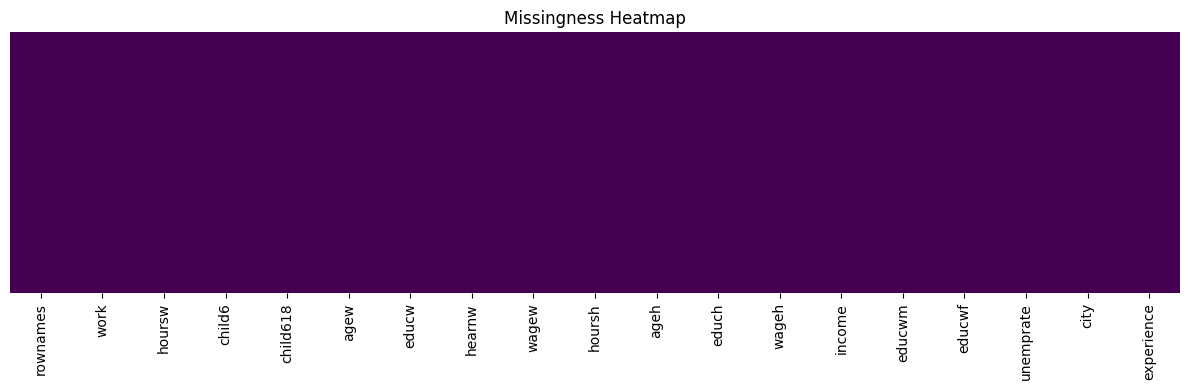


Missing in hearnw: 0.0%
Classification: Structural missingness (MAR) — NOT MCAR.
Action: Retain all 753 rows. Subset to workers only for wage regressions.

Working subsample: 428 observations


In [5]:
print(f"\nMissing values per column:\n{df.isnull().sum()}")

# Visualize missingness
plt.figure(figsize=(12, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missingness Heatmap")
plt.tight_layout()
plt.show()

missing_pct = df['hearnw'].isnull().mean() * 100
print(f"\nMissing in hearnw: {missing_pct:.1f}%")
print("Classification: Structural missingness (MAR) — NOT MCAR.")
print("Action: Retain all 753 rows. Subset to workers only for wage regressions.")

# Subset for wage analysis (working women only)
df_work = df[df['work'] == 'yes'].copy()
print(f"\nWorking subsample: {len(df_work)} observations")

### Requirement 1: Univariate Distribution

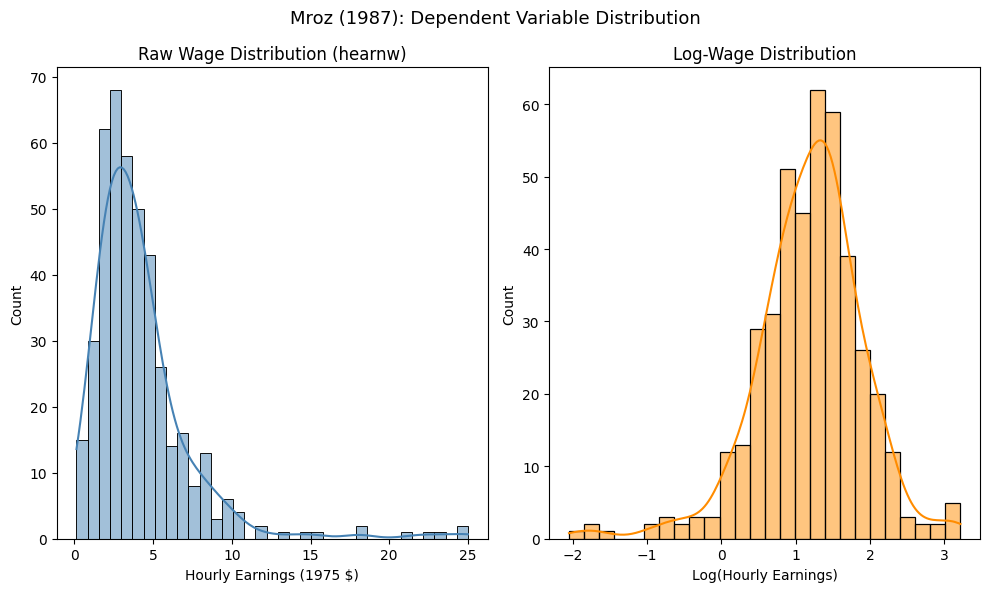

In [6]:
# Plot raw vs. log-transformed hearnw
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_work['hearnw'], kde=True, color='steelblue')
plt.title("Raw Wage Distribution (hearnw)")
plt.xlabel("Hourly Earnings (1975 $)")

plt.subplot(1, 2, 2)
sns.histplot(np.log(df_work['hearnw']), kde=True, color='darkorange')
plt.title("Log-Wage Distribution")
plt.xlabel("Log(Hourly Earnings)")

plt.suptitle("Mroz (1987): Dependent Variable Distribution", fontsize=13)
plt.tight_layout()
plt.show()

# Add log wage to working subsample
df_work['log_hearnw'] = np.log(df_work['hearnw'])

### Requirement 2: Bivariate Relationship

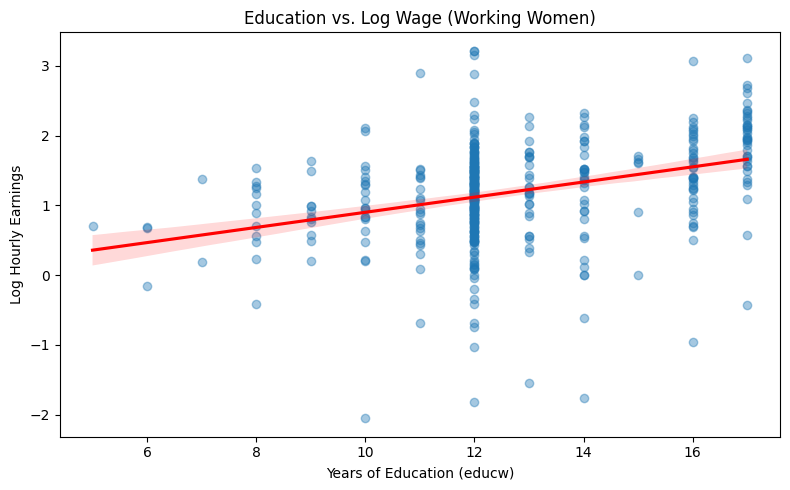

In [7]:
# educw (D) vs. log_hearnw (Y) — continuous, use regplot
plt.figure(figsize=(8, 5))
sns.regplot(data=df_work, x='educw', y='log_hearnw',
            scatter_kws={'alpha': 0.4}, line_kws={'color': 'red'})
plt.title("Education vs. Log Wage (Working Women)")
plt.xlabel("Years of Education (educw)")
plt.ylabel("Log Hourly Earnings")
plt.tight_layout()
plt.show()


### Requirement 3: Outlier Detection (Tukey Fence)


Tukey Fence | Lower: -1.80, Upper: 9.03
Outliers detected: 24 (5.6% of working sample)
      hearnw  educw  experience  agew
39   14.6310     17          11    30
56    9.6354     14          37    55
64   11.9330     12          12    41
110   9.3023     17           7    31
124   9.8611     17           8    47
166  13.5540     17          23    46
184  25.0000     12           2    40
201   9.5057     16           7    34
202  10.6380     17           7    30
209  17.9070     12          12    39


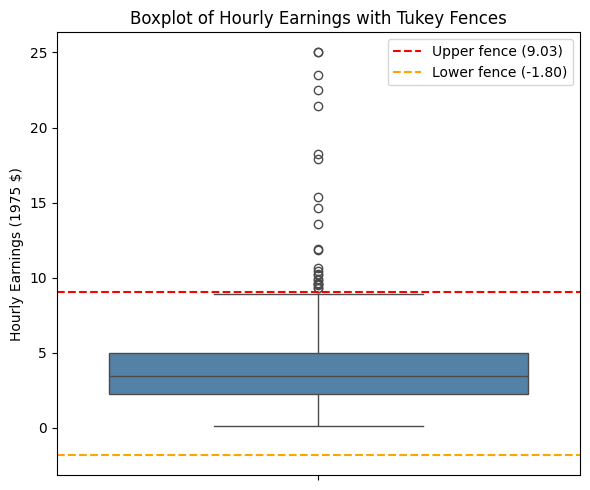

In [8]:
Q1 = df_work['hearnw'].quantile(0.25)
Q3 = df_work['hearnw'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df_work[(df_work['hearnw'] < lower) | (df_work['hearnw'] > upper)]

print(f"\nTukey Fence | Lower: {lower:.2f}, Upper: {upper:.2f}")
print(f"Outliers detected: {len(outliers)} ({len(outliers)/len(df_work)*100:.1f}% of working sample)")
print(outliers[['hearnw', 'educw', 'experience', 'agew']].head(10))

# Visualize outliers on boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(y=df_work['hearnw'], color='steelblue')
plt.axhline(upper, color='red', linestyle='--', label=f'Upper fence ({upper:.2f})')
plt.axhline(lower, color='orange', linestyle='--', label=f'Lower fence ({lower:.2f})')
plt.title("Boxplot of Hourly Earnings with Tukey Fences")
plt.ylabel("Hourly Earnings (1975 $)")
plt.legend()
plt.tight_layout()
plt.show()

### Summary

In [10]:
print("\n Phase 2 Checklist:")
print("  [✓] Libraries imported manually")
print("  [✓] Dirty data addressed (string cleaning + missingness audit)")
print("  [✓] Univariate distribution plotted (raw + log transformation)")
print("  [✓] Bivariate relationship plotted (educw vs. log_hearnw)")
print("  [✓] Outliers identified using manual Tukey Fence method")


 Phase 2 Checklist:
  [✓] Libraries imported manually
  [✓] Dirty data addressed (string cleaning + missingness audit)
  [✓] Univariate distribution plotted (raw + log transformation)
  [✓] Bivariate relationship plotted (educw vs. log_hearnw)
  [✓] Outliers identified using manual Tukey Fence method
